In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import os
import scipy.io as sio

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

from random import randrange

In [2]:
#base directory
base_dir = 'C:/Users/bhavi/Downloads/Untitled Folder/comp/scene_label/data/miml-image-data'
image_dir = os.path.join(base_dir, 'images').replace('\\', '/')

In [23]:
#file containing target labels
mat_file_path = os.path.join(base_dir, 'miml data.mat')
mat_file = sio.loadmat(mat_file_path)

#array of target labels
target_array = mat_file['targets'].T
target_list = [[j if j==1 else 0 for j in row] for row in target_array]

#class list
class_list = [j[0][0] for j in mat_file['class_name']]
print('class labels: {}'.format(class_list))

class labels: ['desert', 'mountains', 'sea', 'sunset', 'trees']


In [4]:
#dataframe containing name of image and target labels
file_list = [str(a)+'.jpg' for a in range(1,2001,1)]
df_train = pd.DataFrame({'image': file_list, 'labels': target_list})

In [5]:
def target_label(x):
    categorical_list = list(np.array(class_list)[np.nonzero(x)])
    return categorical_list
df_train['labels'] = df_train['labels'].apply(lambda x: target_label(x))

#setting aside test images
test_size = 0.2
idx = np.random.RandomState(seed=6).permutation(len(df_train))
test_indices = idx[:int(test_size*len(df_train))]
train_indices = idx[int(test_size*len(df_train)):]
df_test = df_train.iloc[test_indices].reset_index(drop=True)
df_train = df_train.iloc[train_indices].reset_index(drop=True)

In [7]:
from random import seed
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, 
    zoom_range=0.15,
    horizontal_flip=True,
    #vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=0.2,
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=image_dir,
    x_col='image',
    y_col='labels',
    #classes=class_list,
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=True,
    seed=4,
    subset='training'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=image_dir,
    x_col='image',
    y_col='labels',
    #classes=class_list,
    class_mode='categorical',
    batch_size=16,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=False,
    seed=4,
    subset='validation'
)

Found 1280 validated image filenames belonging to 5 classes.
Found 320 validated image filenames belonging to 5 classes.


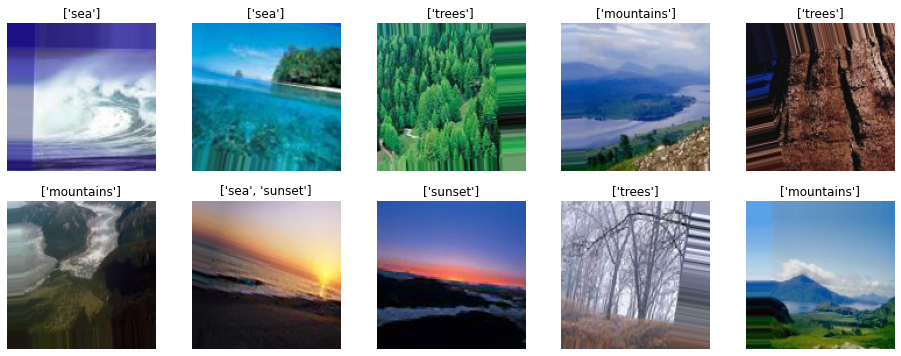

In [8]:
def target_label(x):
    categorical_list = list(np.array(class_list)[np.nonzero(x)])
    return categorical_list

plt.figure(figsize=(16,6))
for image, label in train_generator:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(image[i])
        plt.title(target_label(label[i]))
        #plt.title(label[i])
        plt.axis('off')
    break

In [9]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

inputs = Input(shape=(128,128,3))

x = Conv2D(32, (3,3), activation='relu')( inputs )
x = Conv2D(32, (3,3), activation='relu')( x )
x = BatchNormalization()( x )
x = MaxPooling2D(pool_size=(2,2))( x )

x = Conv2D(64, (3,3), activation='relu')( x )
x = Conv2D(64, (3,3), activation='relu')( x )
x = BatchNormalization()( x )
x = MaxPooling2D(pool_size=(2,2))( x )

x = Conv2D(128, (3,3), activation='relu')( x )
x = Conv2D(128, (3,3), activation='relu')( x )
x = BatchNormalization()( x )
x = MaxPooling2D(pool_size=(2,2))( x )

x = Dropout(0.25)( x )
x = Flatten()( x )
x = Dense(64, activation='relu')( x )
x = Dropout(0.25)( x )
outputs = Dense(5, activation='sigmoid')( x )

model = keras.models.Model( inputs, outputs )

model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['binary_accuracy']
)

In [10]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)
check_point = keras.callbacks.ModelCheckpoint(filepath='scene_label1.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[early_stop, check_point],
    #class_weight=class_weight
)

In [11]:
model.load_weights('scene_label1.h5')

In [12]:
#predictions for validation set
out = model.predict(valid_generator, verbose=0)
#one hot encoding truth labels
y_test = np.zeros((out.shape))
for i, label in enumerate(valid_generator.labels):
    y_test[i, label] = 1


#threshold for classification
threshold = np.arange(0.1,0.9,0.1)
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    acc = []
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append(matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    best_threshold[i] = threshold[index][0]

print('best threshold: {}'.format(best_threshold))

best threshold: [0.2 0.5 0.4 0.3 0.6]


In [13]:
#test images
test_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_dir,
    x_col='image',
    y_col='labels',
    class_mode='categorical',
    batch_size=1,
    target_size=(128,128),
    #color_mode='grayscale',
    shuffle=False,
    seed=4,
)

#test set predictions
out = model.predict(test_generator, verbose=0)

Found 400 validated image filenames belonging to 5 classes.


In [14]:
#one-hot encoding ground truth labels
y_test = np.zeros((out.shape))
for i, label in enumerate(test_generator.labels):
    y_test[i, label] = 1
#predictions after applying tresholds
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])
print('hamming loss on test set: {}'.format(hamming_loss(y_test,y_pred)))

fully_correctly_predicted = len([i for i in range(len(y_test)) if (y_test[i]==y_pred[i]).sum() == 5])
print('fully correctly predicted percentage: {}'.format(fully_correctly_predicted/400.))

hamming loss on test set: 0.1265
fully correctly predicted percentage: 0.585


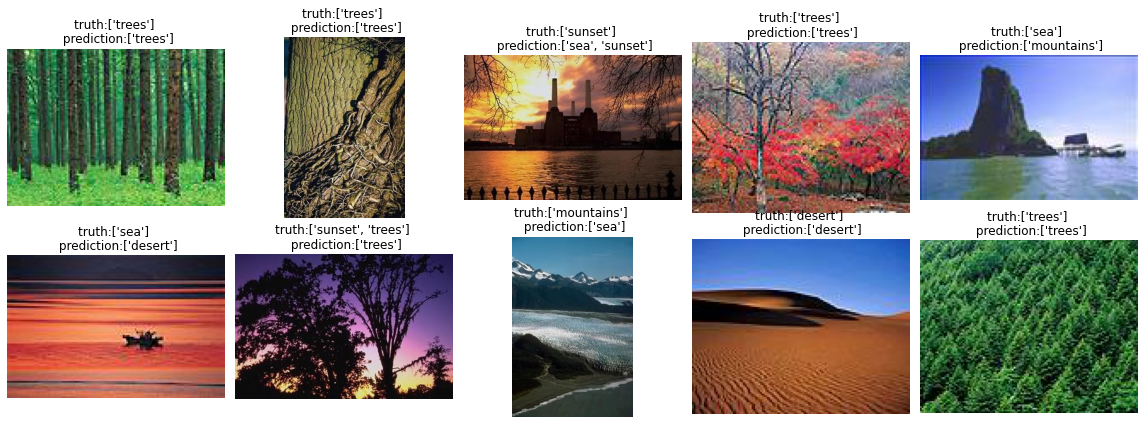

In [15]:
#adding predictions column to dataframe
categorical_label = []
for i in range(y_pred.shape[0]):
    categorical_label.append([])
    categorical_label[i] = target_label(y_pred[i])
df_test['pred'] = categorical_label

#test set predictions images
plt.figure(figsize=(16,6))
for i in range(10):
    idx = randrange(400)
    img_path=os.path.join(image_dir, df_test.loc[idx,'image'])
    plt.subplot(2,5,i+1)
    plt.imshow(plt.imread(img_path))
    plt.title('truth:{} \n prediction:{}'.format(df_test.loc[idx, 'labels'] ,df_test.loc[idx, 'pred']))
    #plt.title(label[i])
    plt.axis('off')
plt.tight_layout()